In [29]:
using JuMP, Ipopt, Plots
using Images, QuartzImageIO, ImageView
dynopt_hickscstr = Model(solver=IpoptSolver());

### The dimensionless dynamic model of a CSTR is given by the following set of equations:
\begin{eqnarray*}
\frac{dy_1}{dt} &=& \frac{1-y_1}{\theta} - k_{10} e^{-N/y_2} y_1 \\
\frac{dy_2}{dt} &=& \frac{y_f-y_2}{\theta} + k_{10} e^{-N/y_2} y_1 - \alpha u (y_2-y_c)
\end{eqnarray*}
### where $y_1=C/C_f$ is the dimensionless concentration, $y_2=T/(J C_f)$ is the dimensionless temperature, $y_c = T_c/(J C_f)$ is the dimensionless coolant temperature, $y_f=T_f/(J C_f)$ is the dimensionless feed stream temperature, $u$ is the cooling flowrate, $\theta=20$ min is the time, $J=100$ K-L/mol is the Arrehnius term, $C_f$ = 7.6 mol/L is the feed stream composition, $\alpha=$ 1.95x10$^{-4}$ is a heat transfer term, $T_f$ = 300 K is the feed stream temperature, $T_c$ = 290 K is the coolant temperature, $k_{10}$ = 300 1/min is the pre-exponential factor and $N=5$ is a constant. 

### The reactor will be operated around the following set of steady-states:

| Plant  |   A     |   B     | C       |
|:------:|:-------:|:-------:|:-------:|
|$y_1$   | 0.0944  |  0.1367 | 0.1926  |
|$y_2$   | 0.7766  |  0.7293 | 0.6881  |
|$u$     | 340     |  390    |  430    | 


### Using the coolant  flowrate ($u$) as the control variables, compute dynamic optimal control policies for the following steady-state process transitions:

* $A \rightarrow B$
* $B \rightarrow A$
* $A \rightarrow C$
* $C \rightarrow A$
* $B \rightarrow C$
* $C \rightarrow B$


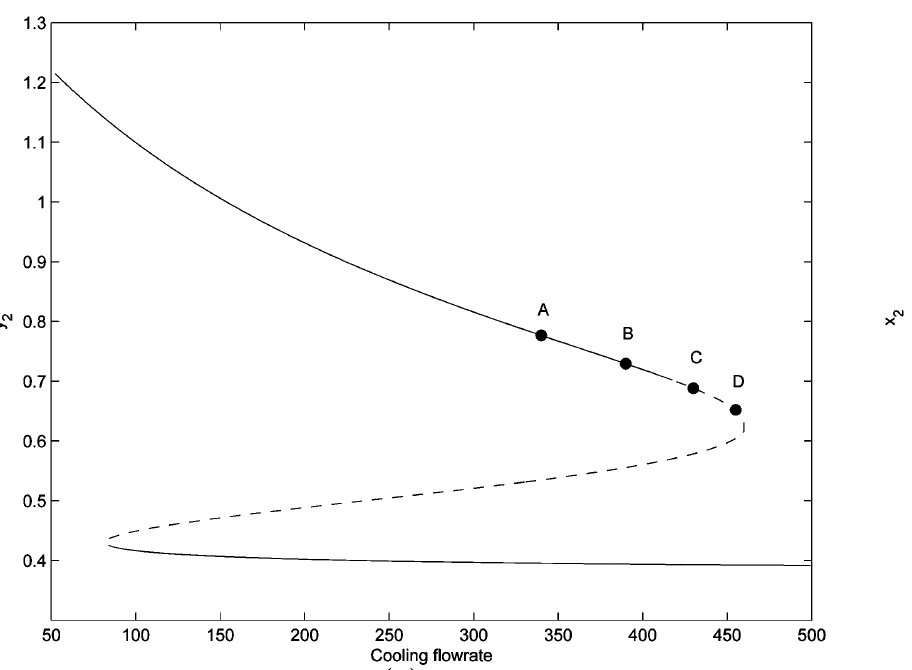

In [16]:
img = load("fig_mss_hicks.png")

In [17]:
#np       = 1:101
np       = 1:301
cf       = 7.6
tff      = 300
tc       = 290
j        = 100
alpha    = 1.95e-04
k10      = 300
n        = 5
theta    = 20                    
y1_init  = 0.0944
y2_init  = 0.7766
u_init   = 340

#y1_end   = 0.1367
#y2_end   = 0.7293
#u_end    = 390

y1_end = 0.1926
y2_end = 0.6881
u_end  = 430

t0       = 0
#tf       = 20
tf       = 150
alpha1   = 1e+06
alpha2   = 2e+03
alpha3   = 1e-03;
yc       = tc/(j*cf);
yf       = tff/(j*cf);

In [18]:
time  = Array{Float64}(undef, length(np))
w     = Array{Float64}(undef, length(np))
dt    = (tf-t0)/(length(np)-1)
for i = 1:length(np)
   time[i] = t0+(i-1)*dt
end
w[1] = 1
w[length(np)] = 1;
for i = 2:length(np)-1
    w[i] = 2
    if mod(i,2) == 0
       w[i] = 4
    end
end

In [19]:
@variable(dynopt_hickscstr, 0   <= y1[np] <= 1,    start = 0.5)
@variable(dynopt_hickscstr, 0   <= y2[np] <= 1,    start = 0.5)
@variable(dynopt_hickscstr, 300 <= u[np]  <= 400,  start = 340);

In [20]:
@constraint(dynopt_hickscstr, icond_y1, y1[1] == y1_init)
@constraint(dynopt_hickscstr, icond_y2, y2[1] == y2_init)
@constraint(dynopt_hickscstr, icond_u , u[1]  == u_init );

In [21]:
@NLconstraint(dynopt_hickscstr, endy1[i in 2:length(np)], 
  y1[i] == y1[i-1] + dt*((1-y1[i])/theta - k10*exp(-n/y2[i])*y1[i] )) ;

In [22]:
@NLconstraint(dynopt_hickscstr, endy2[i in 2:length(np)], 
  y2[i] == y2[i-1] + dt*( (yf-y2[i])/theta + k10*exp(-n/y2[i])*y1[i] 
                            - alpha*u[i]*(y2[i]-yc ))) ;

In [23]:
@NLobjective(dynopt_hickscstr, Min, 
(dt/3)*sum(w[i]*( alpha1*(y1[i]-y1_end)^2 + alpha2*(y2[i]-y2_end)^2 + 
            alpha3*(u[i]-u_end)^2   ) for i in np   )  );

In [24]:
status_dynopt_hickscstr = solve(dynopt_hickscstr);

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2103
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3303

Total number of variables............................:      903
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      903
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [25]:
println("Objective function value = ", getobjectivevalue(dynopt_hickscstr))

Objective function value = 341563.4893577922


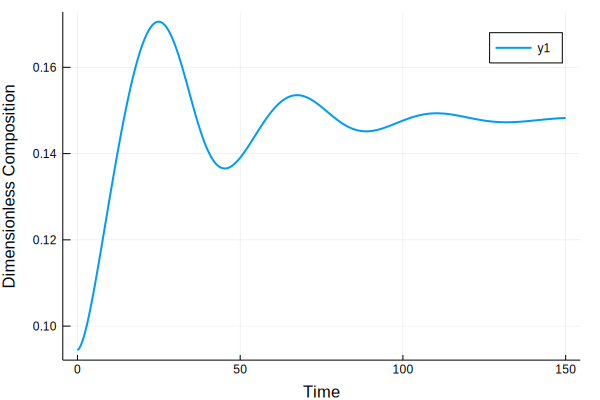

In [26]:
mytime   = Array{Float64}(undef, length(np))                
y1p      = Array{Float64}(undef, length(np))                
y2p      = Array{Float64}(undef, length(np))                
up       = Array{Float64}(undef, length(np))                

for i = 1:length(np)
    mytime[i] = time[i]
    y1p[i]  = getvalue(y1[i])   
    y2p[i]  = getvalue(y2[i])   
    up[i]   = getvalue(u[i])
end    

plot(mytime,y1p,lw=2,xlabel="Time",ylabel="Dimensionless Composition")

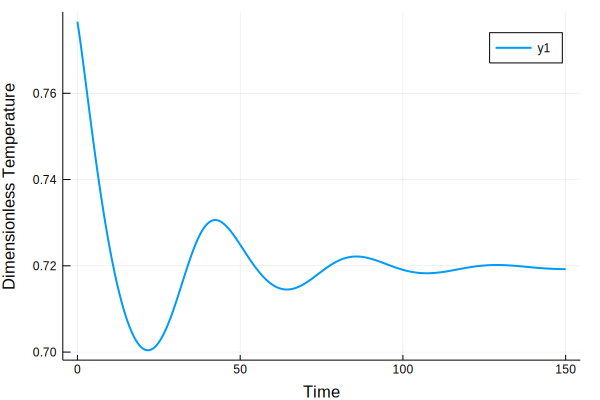

In [27]:
plot(mytime,y2p,lw=2,xlabel="Time",ylabel="Dimensionless Temperature")

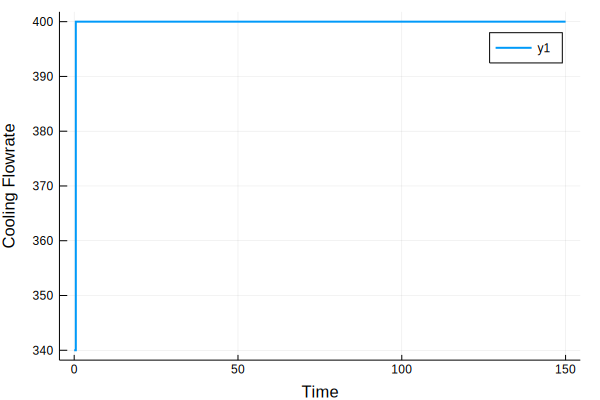

In [28]:
plot(mytime,up,lw=2,linetype=:steppost,xlabel="Time",ylabel="Cooling Flowrate")